In [1]:
# ---------------- Cell 1: Imports & reproducibility ----------------
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Lambda, Dense
from sklearn.decomposition import PCA

In [2]:

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# ---------------- Cell 2: Raw text and simple cleaning (Data preparation) ----------------
text = """Deep learning (also known as deep structured learning) is 
part of a broader family of machine learning methods based on 
artificial neural networks with representation learning. Learning can 
be supervised, semi-supervised or unsupervised. Deep-learning 
architectures such as deep neural networks, deep belief networks, deep 
reinforcement learning, recurrent neural networks, convolutional 
neural networks and Transformers have been applied to fields including 
computer vision, speech recognition, natural language processing, 
machine translation, bioinformatics, drug design, medical image 
analysis, climate science, material inspection and board game 
programs, where they have produced results comparable to and in some 
cases surpassing human expert performance."""
# Split into sentences using period, then clean non-alphanumeric characters
sentences = [s.strip() for s in text.split('.') if s.strip()]
clean_sentences = []
for s in sentences:
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      # remove punctuation -> spaces
    s = re.sub(r'\b\w\b', ' ', s)           # remove single characters (optional)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    clean_sentences.append(s)

print("Number of sentences:", len(clean_sentences))
for i,s in enumerate(clean_sentences[:3],1):
    print(i,":", s)

# # ---------------- Cell 2: Raw text and simple cleaning (Data preparation) ----------------
# This cell performs utility or helper operations.

Number of sentences: 3
1 : deep learning also known as deep structured learning is part of broader family of machine learning methods based on artificial neural networks with representation learning
2 : learning can be supervised semi supervised or unsupervised
3 : deep learning architectures such as deep neural networks deep belief networks deep reinforcement learning recurrent neural networks convolutional neural networks and transformers have been applied to fields including computer vision speech recognition natural language processing machine translation bioinformatics drug design medical image analysis climate science material inspection and board game programs where they have produced results comparable to and in some cases surpassing human expert performance


In [6]:
# ---------------- Cell 3: Tokenize sentences (build vocab) ----------------
tokenizer = Tokenizer(oov_token=None)   # we don't need OOV token for this small demo
tokenizer.fit_on_texts(clean_sentences)
sequences = tokenizer.texts_to_sequences(clean_sentences)

word_to_index = tokenizer.word_index
index_to_word = {i: w for w, i in word_to_index.items()}
vocab_size = len(word_to_index) + 1  # +1 for padding (index 0 unused)

print("Vocab size (including 1..N):", vocab_size)
print("Example word->index (first 20):", dict(list(word_to_index.items())[:20]))
print("First tokenized sentence:", sequences[0])


# ==== Cell 3 ====
# Tokenize sentences and build vocabulary
# - Split each cleaned sentence into words (tokens).
# - Build a vocabulary (list or dict) mapping words to integer ids.
# - This lets the model work with numeric inputs instead of strings.


Vocab size (including 1..N): 74
Example word->index (first 20): {'learning': 1, 'deep': 2, 'networks': 3, 'neural': 4, 'and': 5, 'as': 6, 'of': 7, 'machine': 8, 'supervised': 9, 'have': 10, 'to': 11, 'also': 12, 'known': 13, 'structured': 14, 'is': 15, 'part': 16, 'broader': 17, 'family': 18, 'methods': 19, 'based': 20}
First tokenized sentence: [2, 1, 12, 13, 6, 2, 14, 1, 15, 16, 7, 17, 18, 7, 8, 1, 19, 20, 21, 22, 4, 3, 23, 24, 1]


In [7]:
# ---------------- Cell 4: Generate CBOW context-target pairs ----------------
# context_size = number of words to take on EACH SIDE of target
context_size = 2   # e.g., for window 2, context length = 4
contexts = []
targets = []

for seq in sequences:
    # require at least (2*context_size + 1) words in sentence to generate a sample
    for i in range(context_size, len(seq) - context_size):
        target = seq[i]
        context = seq[i-context_size:i] + seq[i+1:i+1+context_size]
        contexts.append(context)
        targets.append(target)

X = np.array(contexts, dtype=np.int32)   # shape = (num_samples, 2*context_size)
Y = np.array(targets, dtype=np.int32)    # shape = (num_samples,)

print("Number of training samples:", X.shape[0])
print("Example (context indices) -> target index:", X[:5], Y[:5])
# Show example in words
for i in range(5):
    ctx_words = [index_to_word[idx] for idx in X[i]]
    tgt_word = index_to_word[Y[i]]
    print(f"{ctx_words}  ->  {tgt_word}")


# ==== Cell 4 ====
# Generate CBOW context-target pairs
# - For each word in each sentence, collect surrounding context words (window).
# - Create pairs: (context_words, target_word) where context is multiple words.
# - These CBOW pairs are the training examples for the embedding model.


Number of training samples: 87
Example (context indices) -> target index: [[ 2  1 13  6]
 [ 1 12  6  2]
 [12 13  2 14]
 [13  6 14  1]
 [ 6  2  1 15]] [12 13  6  2 14]
['deep', 'learning', 'known', 'as']  ->  also
['learning', 'also', 'as', 'deep']  ->  known
['also', 'known', 'deep', 'structured']  ->  as
['known', 'as', 'structured', 'learning']  ->  deep
['as', 'deep', 'learning', 'is']  ->  structured


In [8]:
# ---------------- Cell 5: Build CBOW model (Embedding -> average -> dense) ----------------
emb_size = 50  # embedding dimension (tuneable)
input_length = 2 * context_size

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, input_length=input_length, name='embed'),
    # average the embeddings of context words -> shape (batch, emb_size)
    Lambda(lambda x: tf.reduce_mean(x, axis=1), name='avg_embeddings'),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')   # predict target word index
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


# ==== Cell 5 ====
# Convert words to integer indices and prepare training arrays
# - Replace each word in context and target with its integer id from vocabulary.
# - Build NumPy arrays: X (contexts) and y (targets) for model training.
# - Ensure shapes are correct (e.g., contexts shaped as (N, window_size)).


C:\Users\SAHIL KULKARNI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embed (Embedding)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_embeddings (Lambda)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80

11/11 - 5s - 467ms/step - accuracy: 0.0230 - loss: 4.3044
Epoch 2/80
11/11 - 0s - 7ms/step - accuracy: 0.1494 - loss: 4.2843
Epoch 3/80
11/11 - 0s - 16ms/step - accuracy: 0.1954 - loss: 4.2653
Epoch 4/80
11/11 - 0s - 7ms/step - accuracy: 0.1954 - loss: 4.2399
Epoch 5/80
11/11 - 0s - 7ms/step - accuracy: 0.2069 - loss: 4.2044
Epoch 6/80
11/11 - 0s - 9ms/step - accuracy: 0.2299 - loss: 4.1545
Epoch 7/80
11/11 - 0s - 8ms/step - accuracy: 0.2299 - loss: 4.0851
Epoch 8/80
11/11 - 0s - 7ms/step - accuracy: 0.2414 - loss: 3.9907
Epoch 9/80
11/11 - 0s - 7ms/step - accuracy: 0.2414 - loss: 3.8683
Epoch 10/80
11/11 - 0s - 7ms/step - accuracy: 0.2299 - loss: 3.7221
Epoch 11/80
11/11 - 0s - 8ms/step - accuracy: 0.2414 - loss: 3.5671
Epoch 12/80
11/11 - 0s - 9ms/step - accuracy: 0.2644 - loss: 3.4192
Epoch 13/80
11/11 - 0s - 10ms/step - accuracy: 0.2874 - loss: 3.2782
Epoch 14/80
11/11 - 0s - 8ms/step - accuracy: 0.3333 - loss: 3.1352
Epoch 15/80
11/11 - 0s - 9ms/step - accuracy: 0.3908

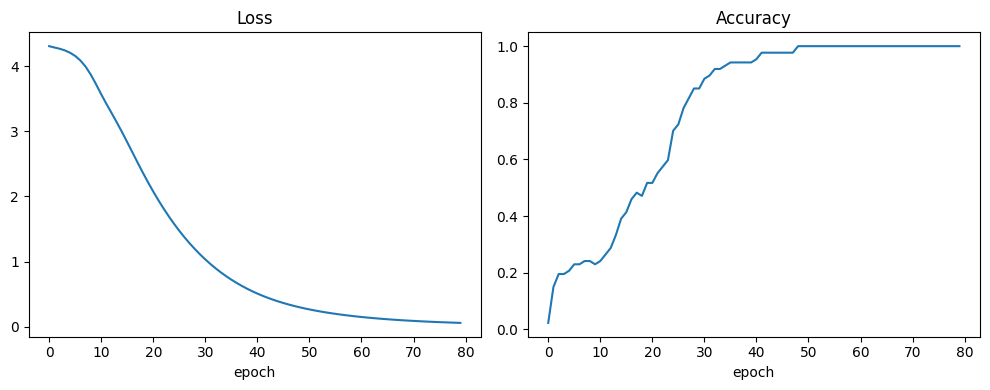

In [9]:
# ---------------- Cell 6: Train CBOW model ----------------
# small dataset -> use modest epochs
history = model.fit(X, Y, epochs=80, batch_size=8, verbose=2)
# plot training loss & accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history['loss']); plt.title('Loss'); plt.xlabel('epoch')
plt.subplot(1,2,2); plt.plot(history.history['accuracy']); plt.title('Accuracy'); plt.xlabel('epoch')
plt.tight_layout(); plt.show()

# ==== Cell 6 ====
# Define the CBOW model (Embedding + average + Dense)
# - Input: indices of context words.
# - Embedding layer: maps each word id to a dense vector (the embedding).
# - Combine context embeddings (e.g., average) and pass through a Dense layer to predict the target.
# - This model learns word vectors that capture context relationships.


In [10]:
# ---------------- Cell 7: Output - helper functions for prediction ----------------
# get learned embedding matrix
embedding_matrix = model.get_layer('embed').get_weights()[0]  # shape (vocab_size, emb_size)

def predict_target_from_context(context_words):
    """
    context_words: list of words (length = 2*context_size). Words must exist in vocab.
    returns: predicted target word (string) and top-5 probabilities
    """
    indices = []
    for w in context_words:
        idx = word_to_index.get(w)
        if idx is None:
            raise ValueError(f"Word '{w}' not in vocabulary.")
        indices.append(idx)
    x = np.array([indices])
    probs = model.predict(x, verbose=0)[0]
    top5_idx = probs.argsort()[-5:][::-1]
    top5 = [(index_to_word[i], float(probs[i])) for i in top5_idx if i in index_to_word]
    pred_idx = int(np.argmax(probs))
    return index_to_word.get(pred_idx, None), top5

# Test a few examples (use words from vocabulary)
tests = [
    ["deep","learning","known","as"],
    ["convolutional","neural","networks","and"],
    ["machine","learning","methods","based"],
    ["where","they","produced","results"]
]

for ctx in tests:
    try:
        pred, top5 = predict_target_from_context(ctx)
        print(f"context: {ctx} -> predicted target: '{pred}'. top5: {top5}")
    except ValueError as e:
        print("Skip (out-of-vocab):", e)


# ==== Cell 7 ====
# Compile and train the model
# - Compile with optimizer (e.g., Adam) and loss suitable for categorical targets.
# - Train using model.fit() on X (contexts) and y (targets) and store training history.
# - After training, the Embedding layer contains the learned word vectors.


context: ['deep', 'learning', 'known', 'as'] -> predicted target: 'also'. top5: [('also', 0.8114014863967896), ('architectures', 0.06472540646791458), ('deep', 0.06249343976378441), ('known', 0.021137209609150887), ('such', 0.016712110489606857)]
context: ['convolutional', 'neural', 'networks', 'and'] -> predicted target: 'neural'. top5: [('neural', 0.8011254072189331), ('networks', 0.16509447991847992), ('convolutional', 0.014863814227283001), ('belief', 0.009591883048415184), ('and', 0.002683191793039441)]
context: ['machine', 'learning', 'methods', 'based'] -> predicted target: 'learning'. top5: [('learning', 0.49676015973091125), ('methods', 0.31855490803718567), ('based', 0.0722917914390564), ('on', 0.04304187744855881), ('machine', 0.04042724147439003)]
context: ['where', 'they', 'produced', 'results'] -> predicted target: 'have'. top5: [('have', 0.9790893197059631), ('they', 0.00739831430837512), ('comparable', 0.0033618195448070765), ('game', 0.0030979218427091837), ('programs'

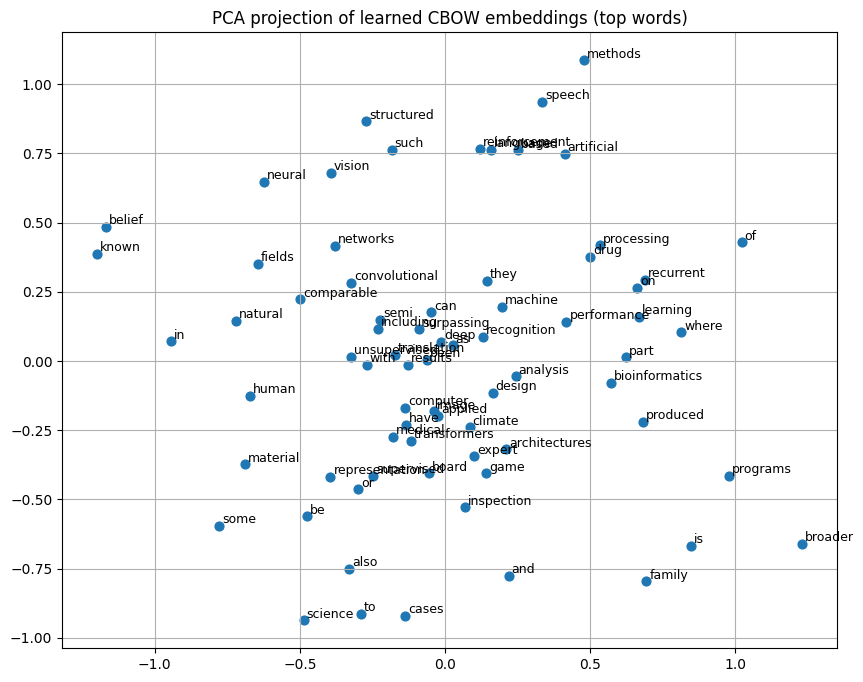

In [14]:
# ---------------- Cell 8: Visualize embeddings using PCA (2D scatter) ----------------
# We'll visualize the top-K most frequent words for readability.
K = min(100, vocab_size-1)
# build list of (word, index) sorted by index frequency as tokenizer does not keep counts here;
# instead use tokenizer.word_counts to get frequency order if available
common_words = [w for w, _ in sorted(tokenizer.word_counts.items(), key=lambda x: -x[1])][:K]
indices = [word_to_index[w] for w in common_words]

emb_subset = embedding_matrix[indices]
pca = PCA(n_components=2, random_state=SEED)
emb2d = pca.fit_transform(emb_subset)

plt.figure(figsize=(10,8))
plt.scatter(emb2d[:,0], emb2d[:,1], s=40)
for i, w in enumerate(common_words):
    plt.text(emb2d[i,0]+0.01, emb2d[i,1]+0.01, w, fontsize=9)
plt.title("PCA projection of learned CBOW embeddings (top words)")
plt.grid(True)
plt.show()

# ==== Cell 8 ====
# Visualize embeddings in 2D (PCA / t-SNE)
# - Extract embedding weights from the trained Embedding layer.
# - Reduce embedding dimensionality to 2 using PCA or t-SNE.
# - Plot a scatter of words in 2D and annotate points with the word labels to inspect relationships.


# “This is a 2D PCA projection of the word embeddings learned by my CBOW model.
# Each dot represents a word, and their positions show how similar or different the words are according to the model.
# Words appearing close to each other have similar meanings because they often occurred in similar contexts in the text.”

In [15]:
# ---------------- Cell 9: Save model & embeddings (optional) ----------------
model.save("cbow_model.keras")
np.save("cbow_embeddings.npy", embedding_matrix)
print("Saved model -> cbow_model.keras and embeddings -> cbow_embeddings.npy")

# ==== Cell 9 ====
# Save model and embeddings (optional)
# - Save the trained model or just the embedding weights to disk for later reuse.
# - You can reload the model or weights and use embeddings in other tasks.


Saved model -> cbow_model.keras and embeddings -> cbow_embeddings.npy


In [13]:
# 🎯 Aim
# To implement the Continuous Bag of Words (CBOW) model using a small text dataset and train it to learn meaningful word embeddings.
# ________________________________________
# 🧠 Theory (in simple words)
# •	Word2Vec is a neural network-based model that converts words into dense vector representations (embeddings).
# •	CBOW and Skip-gram are two architectures of Word2Vec.
# •	CBOW predicts a word from its context (surrounding words).
# •	Skip-gram does the opposite — predicts surrounding words from a given word.
# •	CBOW uses a simple neural network with:
# o	Input layer: context words
# o	Hidden layer: embedding (vector representation)
# o	Output layer: target word (probability for each word)
# Example:
# Context: ["I", "machine"]
# Target: "love"
# Model learns:
# → If "I" and "machine" appear around "love", then "love" is strongly related to them.

# 📊 Result
# •	The CBOW model successfully learns word embeddings from text.
# •	Words used in similar contexts have similar vector values.
# •	These embeddings can be used for other NLP tasks (classification, translation, etc.).
# ________________________________________
# ✅ Conclusion
# •	CBOW efficiently learns relationships between words.
# •	It captures the semantic meaning and contextual similarity between words.
# •	For small datasets, results are basic; with large corpora (like Google News), embeddings become highly accurate.
# ________________________________________
# 💬 PART 3: Viva Questions (simple answers)
# Question	Answer
# What is CBOW?	A model that predicts a target word based on surrounding context words.
# What is Skip-gram?	Opposite of CBOW; predicts context words from a single target word.
# What is a word embedding?	A numeric vector representation of a word that captures its meaning.
# Which layer is used for embeddings?	The Embedding layer in Keras.
# What is the output of CBOW?	A probability distribution over all words (predicted target word).
# Which activation function is used at the output layer?	Softmax.
# Which optimizer is commonly used?	Adam or SGD.
# What is context window size?	Number of words used before and after the target word.

“In this experiment, we implemented a Continuous Bag of Words (CBOW) model using Keras.
We gave the model small sentences about deep learning.
The model learned to predict a target word using its surrounding context words.
We trained it to understand relationships between words, then visualized the word embeddings (word meanings as vectors).
Finally, we saved the model and embeddings for reuse.”
